In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import torch as th
import torch.nn as nn
import dgl
from dgl import function as fn
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from dgl import DGLGraph
import torch.nn.functional as F
from torch.autograd import Variable
import time
import seaborn
from geopy.distance import geodesic

Using backend: pytorch


## 实验准备

In [3]:
class TAGConv(nn.Module):
    def __init__(self,
                 in_feats,    
                 out_feats,   
                 k=2,         
                 bias=True,   
                 activation=None): 
        super(TAGConv, self).__init__()   
        self._in_feats = in_feats  
        self._out_feats = out_feats 
        self._k = k
        self._activation = activation
        self.lin = nn.Linear(in_feats * (self._k + 1), out_feats, bias=bias) 

        self.reset_parameters() 


    def reset_parameters(self):      
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')     
        nn.init.xavier_normal_(self.lin.weight, gain=gain)   

        
    def forward(self, graph, feat):    
        graph = graph.local_var()           
        
        norm = th.pow(graph.in_degrees().float().clamp(min=1), -0.5) 
    
        
        shp = norm.shape + (1,) * (feat.dim() - 1)    
        
        norm = th.reshape(norm, shp).to(feat.device)  

        #D-1/2 A D -1/2 X
        fstack = [feat]      
        for _ in range(self._k):

            rst = fstack[-1] * norm    
            
            graph.ndata['h'] = rst     

            graph.update_all(fn.copy_src(src='h', out='m'),   
                             fn.sum(msg='m', out='h'))     
           
            
            rst = graph.ndata['h']     
            rst = rst * norm           
            fstack.append(rst)         

        rst = self.lin(th.cat(fstack, dim=-1))    

        if self._activation is not None:
            rst = self._activation(rst)             

        return rst

In [4]:
class GCN(nn.Module):
   
    def __init__(self,input_dim,hidden_size,num_classes):
        super(GCN, self).__init__()
        self.gcn1 = TAGConv(input_dim,hidden_size,k=1)
        self.gcn2 = TAGConv(hidden_size, num_classes,k=1)
        #self.linear = nn.Linear(hidden_size, num_classes)
        #self.dropout = nn.Dropout(0.5)
        
    def forward(self, graph, feature):
        h = F.relu(self.gcn1(graph, feature))    #隐藏层运算
        h = self.gcn2(graph, h)           #全连接层运算
        return h

In [5]:
relation1 = np.loadtxt(fname="data_US/relation1.csv", dtype=int, delimiter=",")
city_or_area_num = len(relation1)
print(city_or_area_num)
relation1

500


array([[1, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1]])

In [6]:
relation2 = np.loadtxt(fname="data_US/relation2.csv", dtype=int, delimiter=",")
relation2

array([[1, 0, 1, ..., 1, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 0, 1]])

In [7]:
relation3 = np.loadtxt(fname="data_US/relation3.csv", dtype=int, delimiter=",")
relation3

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 0, 1],
       [1, 0, 1, ..., 1, 1, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1]])

In [8]:
relation4 = np.loadtxt(fname="data_US/relation4.csv", dtype=int, delimiter=",")
relation4

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [9]:
GQC=dgl.DGLGraph()
GQC.add_nodes(city_or_area_num) #327
for i in range(city_or_area_num):
    for j in range(city_or_area_num):
        if relation1[i][j]==1:
            GQC.add_edge(i, j)
        else:
            pass
GQC

E:\1_software\Anaconda3\envs\pytorch\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
E:\1_software\Anaconda3\envs\pytorch\lib\site-packages\dgl\base.py:45: DGLWarning: DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges
  return warnings.warn(message, category=category, stacklevel=1)


Graph(num_nodes=500, num_edges=49604,
      ndata_schemes={}
      edata_schemes={})

In [10]:
GLC = dgl.DGLGraph()
GLC.add_nodes(city_or_area_num) #327
for i in range(city_or_area_num):
    for j in range(city_or_area_num):
        if relation2[i][j]==1:
            GLC.add_edge(i, j)
        else:
            pass
GLC

Graph(num_nodes=500, num_edges=99702,
      ndata_schemes={}
      edata_schemes={})

In [11]:
GLF = dgl.DGLGraph()
GLF.add_nodes(city_or_area_num) #327
for i in range(city_or_area_num):
    for j in range(city_or_area_num):
        if relation3[i][j]==1:
            GLF.add_edge(i, j)
        else:
            pass
GLF

Graph(num_nodes=500, num_edges=149804,
      ndata_schemes={}
      edata_schemes={})

In [12]:
GQF = dgl.DGLGraph()
GQF.add_nodes(city_or_area_num) #327
for i in range(city_or_area_num):
    for j in range(city_or_area_num):
        if relation4[i][j]==1:
            GQF.add_edge(i, j)
        else:
            pass
GQF

Graph(num_nodes=500, num_edges=199902,
      ndata_schemes={}
      edata_schemes={})

In [13]:
df = pd.read_csv('data_US/confirmed.csv',index_col=[0])
print(len(df.columns))
df

484


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21
Combined_Key,,,,,,,,,,,,,,,,,,,,,
"Ripley, Indiana, US",0,0,0,0,0,0,0,0,0,0,...,3396,3397,3399,3401,3402,3404,3408,3407,3407,3409
"Boyd, Nebraska, US",0,0,0,0,0,0,0,0,0,0,...,176,176,176,176,176,176,176,176,176,176
"Poquoson, Virginia, US",0,0,0,0,0,0,0,0,0,0,...,873,873,873,874,875,875,875,875,875,875
"Anderson, Kansas, US",0,0,0,0,0,0,0,0,0,0,...,836,836,837,837,837,837,837,837,837,838
"Murray, Oklahoma, US",0,0,0,0,0,0,0,0,0,0,...,2014,2014,2017,2017,2017,2017,2017,2017,2017,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Calhoun, Georgia, US",0,0,0,0,0,0,0,0,0,0,...,585,585,586,587,587,586,586,586,586,586
"Ward, North Dakota, US",0,0,0,0,0,0,0,0,0,0,...,9717,9723,9734,9740,9748,9759,9770,9772,9788,9808
"Pontotoc, Mississippi, US",0,0,0,0,0,0,0,0,0,0,...,4200,4201,4201,4207,4208,4208,4208,4211,4213,4216


In [14]:
def gen_lab(dataset, start, end, experience, future):   
    data = []
    labels = []
    data_list = []
    labels_list = []

    real_start = start + experience     

    for i in range(real_start, end):    
        data.append(dataset.iloc[:,i-experience:i])    
        labels.append(dataset.iloc[:,i:i+future])    
    #print(labels)
    
    for j in range(len(data)):
        data_tensor = th.Tensor(np.array(data[j]))
        data_list.append(data_tensor)
    
    for k in range(len(labels)):
        labels_tensor = th.Tensor(np.array(labels[k]))
        labels_list.append(labels_tensor)
    
    return th.stack(data_list), th.stack(labels_list)

In [15]:
df_n = (df-df.min())/(df.max()-df.min())
#print(df_n.iloc[:,6:7].T)

train_x,train_y = gen_lab(df_n,100,300,7,1)
valid_x,valid_y = gen_lab(df_n,300,400,7,1)
test_x,test_y = gen_lab(df_n,400,480,7,1)

In [16]:
train_x.shape,train_y.shape,valid_x.shape,test_x.shape

(torch.Size([193, 500, 7]),
 torch.Size([193, 500, 1]),
 torch.Size([93, 500, 7]),
 torch.Size([73, 500, 7]))

In [17]:
def gcn_trainer(network,graph,input_data,label_data,training_times,
                optimizer,criterion,loss_list,dur_list):

    #loss_list = loss_list
    #network = network

    for epoch in range(training_times):
        t0 = time.time()
        network.train()
        out = network(graph,input_data)          
        
        #criterion = criterion
        loss = criterion(out,label_data)
        
        #optimizer = optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        dur_list.append(time.time() - t0)
        
        if (epoch+1) % 50 == 0:
            #acc = evaluate(net, g, features, labels, test_mask)
            print("Epoch {:04d} | MAE_Test_Loss {:.4f}".format(epoch+1, loss.item())) 

In [18]:
QCGCN=GCN(7,14,1);QCGCN_Loss_list=[];QCGCN_Loss_list.clear();QCGCN_MAE_Dur_list=[]
for i in range(len(train_x)):
    print('Batch{:d}: '.format(i+1),end='')
    gcn_trainer(QCGCN,GQC,train_x[i],train_y[i],50,th.optim.Adam(QCGCN.parameters(), lr=1e-3),nn.L1Loss(),QCGCN_Loss_list,QCGCN_MAE_Dur_list)

Batch1: Epoch 0050 | MAE_Test_Loss 0.0086
Batch2: Epoch 0050 | MAE_Test_Loss 0.0028
Batch3: Epoch 0050 | MAE_Test_Loss 0.0021
Batch4: Epoch 0050 | MAE_Test_Loss 0.0017
Batch5: Epoch 0050 | MAE_Test_Loss 0.0016
Batch6: Epoch 0050 | MAE_Test_Loss 0.0017
Batch7: Epoch 0050 | MAE_Test_Loss 0.0016
Batch8: Epoch 0050 | MAE_Test_Loss 0.0015
Batch9: Epoch 0050 | MAE_Test_Loss 0.0016
Batch10: Epoch 0050 | MAE_Test_Loss 0.0016
Batch11: Epoch 0050 | MAE_Test_Loss 0.0015
Batch12: Epoch 0050 | MAE_Test_Loss 0.0014
Batch13: Epoch 0050 | MAE_Test_Loss 0.0013
Batch14: Epoch 0050 | MAE_Test_Loss 0.0014
Batch15: Epoch 0050 | MAE_Test_Loss 0.0013
Batch16: Epoch 0050 | MAE_Test_Loss 0.0014
Batch17: Epoch 0050 | MAE_Test_Loss 0.0013
Batch18: Epoch 0050 | MAE_Test_Loss 0.0012
Batch19: Epoch 0050 | MAE_Test_Loss 0.0012
Batch20: Epoch 0050 | MAE_Test_Loss 0.0012
Batch21: Epoch 0050 | MAE_Test_Loss 0.0012
Batch22: Epoch 0050 | MAE_Test_Loss 0.0012
Batch23: Epoch 0050 | MAE_Test_Loss 0.0013
Batch24: Epoch 0050 

Batch190: Epoch 0050 | MAE_Test_Loss 0.0004
Batch191: Epoch 0050 | MAE_Test_Loss 0.0004
Batch192: Epoch 0050 | MAE_Test_Loss 0.0004
Batch193: Epoch 0050 | MAE_Test_Loss 0.0004


In [19]:
LCGCN=GCN(7,14,1);LCGCN_Loss_list=[];LCGCN_Loss_list.clear();LCGCN_MAE_Dur_list=[]
for i in range(len(train_x)):
    print('Batch{:d}: '.format(i+1),end='')
    gcn_trainer(LCGCN,GLC,train_x[i],train_y[i],50,th.optim.Adam(LCGCN.parameters(), lr=1e-3),nn.L1Loss(),LCGCN_Loss_list,LCGCN_MAE_Dur_list)

Batch1: Epoch 0050 | MAE_Test_Loss 0.0123
Batch2: Epoch 0050 | MAE_Test_Loss 0.0043
Batch3: Epoch 0050 | MAE_Test_Loss 0.0019
Batch4: Epoch 0050 | MAE_Test_Loss 0.0016
Batch5: Epoch 0050 | MAE_Test_Loss 0.0014
Batch6: Epoch 0050 | MAE_Test_Loss 0.0014
Batch7: Epoch 0050 | MAE_Test_Loss 0.0014
Batch8: Epoch 0050 | MAE_Test_Loss 0.0014
Batch9: Epoch 0050 | MAE_Test_Loss 0.0014
Batch10: Epoch 0050 | MAE_Test_Loss 0.0013
Batch11: Epoch 0050 | MAE_Test_Loss 0.0012
Batch12: Epoch 0050 | MAE_Test_Loss 0.0011
Batch13: Epoch 0050 | MAE_Test_Loss 0.0010
Batch14: Epoch 0050 | MAE_Test_Loss 0.0011
Batch15: Epoch 0050 | MAE_Test_Loss 0.0011
Batch16: Epoch 0050 | MAE_Test_Loss 0.0011
Batch17: Epoch 0050 | MAE_Test_Loss 0.0010
Batch18: Epoch 0050 | MAE_Test_Loss 0.0010
Batch19: Epoch 0050 | MAE_Test_Loss 0.0009
Batch20: Epoch 0050 | MAE_Test_Loss 0.0009
Batch21: Epoch 0050 | MAE_Test_Loss 0.0011
Batch22: Epoch 0050 | MAE_Test_Loss 0.0010
Batch23: Epoch 0050 | MAE_Test_Loss 0.0010
Batch24: Epoch 0050 

Batch190: Epoch 0050 | MAE_Test_Loss 0.0004
Batch191: Epoch 0050 | MAE_Test_Loss 0.0003
Batch192: Epoch 0050 | MAE_Test_Loss 0.0003
Batch193: Epoch 0050 | MAE_Test_Loss 0.0003


In [20]:
LFGCN=GCN(7,14,1);LFGCN_Loss_list=[];LFGCN_Loss_list.clear();LFGCN_MAE_Dur_list=[]
for i in range(len(train_x)):
    print('Batch{:d}: '.format(i+1),end='')
    gcn_trainer(LFGCN,GLF,train_x[i],train_y[i],50,th.optim.Adam(LFGCN.parameters(), lr=1e-3),nn.L1Loss(),LFGCN_Loss_list,LFGCN_MAE_Dur_list)

Batch1: Epoch 0050 | MAE_Test_Loss 0.0297
Batch2: Epoch 0050 | MAE_Test_Loss 0.0088
Batch3: Epoch 0050 | MAE_Test_Loss 0.0054
Batch4: Epoch 0050 | MAE_Test_Loss 0.0037
Batch5: Epoch 0050 | MAE_Test_Loss 0.0027
Batch6: Epoch 0050 | MAE_Test_Loss 0.0018
Batch7: Epoch 0050 | MAE_Test_Loss 0.0014
Batch8: Epoch 0050 | MAE_Test_Loss 0.0012
Batch9: Epoch 0050 | MAE_Test_Loss 0.0010
Batch10: Epoch 0050 | MAE_Test_Loss 0.0009
Batch11: Epoch 0050 | MAE_Test_Loss 0.0009
Batch12: Epoch 0050 | MAE_Test_Loss 0.0007
Batch13: Epoch 0050 | MAE_Test_Loss 0.0009
Batch14: Epoch 0050 | MAE_Test_Loss 0.0007
Batch15: Epoch 0050 | MAE_Test_Loss 0.0007
Batch16: Epoch 0050 | MAE_Test_Loss 0.0007
Batch17: Epoch 0050 | MAE_Test_Loss 0.0006
Batch18: Epoch 0050 | MAE_Test_Loss 0.0006
Batch19: Epoch 0050 | MAE_Test_Loss 0.0007
Batch20: Epoch 0050 | MAE_Test_Loss 0.0009
Batch21: Epoch 0050 | MAE_Test_Loss 0.0007
Batch22: Epoch 0050 | MAE_Test_Loss 0.0008
Batch23: Epoch 0050 | MAE_Test_Loss 0.0008
Batch24: Epoch 0050 

Batch190: Epoch 0050 | MAE_Test_Loss 0.0015
Batch191: Epoch 0050 | MAE_Test_Loss 0.0017
Batch192: Epoch 0050 | MAE_Test_Loss 0.0016
Batch193: Epoch 0050 | MAE_Test_Loss 0.0017


In [21]:
QFGCN=GCN(7,14,1);QFGCN_Loss_list=[];QFGCN_Loss_list.clear();QFGCN_MAE_Dur_list=[]
for i in range(len(train_x)):
    print('Batch{:d}: '.format(i+1),end='')
    gcn_trainer(QFGCN,GQF,train_x[i],train_y[i],50,th.optim.Adam(QFGCN.parameters(), lr=1e-3),nn.L1Loss(),QFGCN_Loss_list,QFGCN_MAE_Dur_list)

Batch1: Epoch 0050 | MAE_Test_Loss 0.0363
Batch2: Epoch 0050 | MAE_Test_Loss 0.0064
Batch3: Epoch 0050 | MAE_Test_Loss 0.0031
Batch4: Epoch 0050 | MAE_Test_Loss 0.0026
Batch5: Epoch 0050 | MAE_Test_Loss 0.0024
Batch6: Epoch 0050 | MAE_Test_Loss 0.0023
Batch7: Epoch 0050 | MAE_Test_Loss 0.0023
Batch8: Epoch 0050 | MAE_Test_Loss 0.0021
Batch9: Epoch 0050 | MAE_Test_Loss 0.0019
Batch10: Epoch 0050 | MAE_Test_Loss 0.0018
Batch11: Epoch 0050 | MAE_Test_Loss 0.0015
Batch12: Epoch 0050 | MAE_Test_Loss 0.0014
Batch13: Epoch 0050 | MAE_Test_Loss 0.0014
Batch14: Epoch 0050 | MAE_Test_Loss 0.0014
Batch15: Epoch 0050 | MAE_Test_Loss 0.0013
Batch16: Epoch 0050 | MAE_Test_Loss 0.0013
Batch17: Epoch 0050 | MAE_Test_Loss 0.0012
Batch18: Epoch 0050 | MAE_Test_Loss 0.0011
Batch19: Epoch 0050 | MAE_Test_Loss 0.0009
Batch20: Epoch 0050 | MAE_Test_Loss 0.0009
Batch21: Epoch 0050 | MAE_Test_Loss 0.0010
Batch22: Epoch 0050 | MAE_Test_Loss 0.0011
Batch23: Epoch 0050 | MAE_Test_Loss 0.0010
Batch24: Epoch 0050 

Batch190: Epoch 0050 | MAE_Test_Loss 0.0005
Batch191: Epoch 0050 | MAE_Test_Loss 0.0005
Batch192: Epoch 0050 | MAE_Test_Loss 0.0004
Batch193: Epoch 0050 | MAE_Test_Loss 0.0008


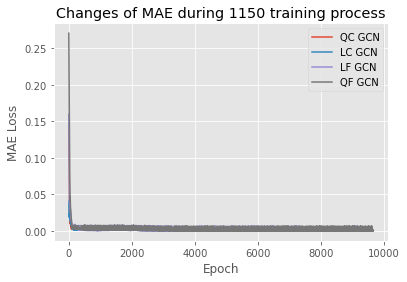

In [22]:
plt.style.use('ggplot')
QCGCN_Loss_list_numpy = []
LCGCN_Loss_list_numpy = []
LFGCN_Loss_list_numpy = []
QFGCN_Loss_list_numpy = []
for i in QCGCN_Loss_list:
    QCGCN_Loss_list_numpy.append(i.detach().numpy())
for i in LCGCN_Loss_list:
    LCGCN_Loss_list_numpy.append(i.detach().numpy())
for i in LFGCN_Loss_list:
    LFGCN_Loss_list_numpy.append(i.detach().numpy())
for i in QFGCN_Loss_list:
    QFGCN_Loss_list_numpy.append(i.detach().numpy())
    
plt.plot(QCGCN_Loss_list_numpy,label='QC GCN')
plt.plot(LCGCN_Loss_list_numpy,label='LC GCN')
plt.plot(LFGCN_Loss_list_numpy,label='LF GCN')
plt.plot(QFGCN_Loss_list_numpy,label='QF GCN')
plt.title('Changes of MAE during 1150 training process')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend(loc=1)
plt.show()

In [23]:
QCGCN_During=np.sum(QCGCN_MAE_Dur_list)
LCGCN_During=np.sum(LCGCN_MAE_Dur_list)
LFGCN_During=np.sum(LFGCN_MAE_Dur_list)
QFGCN_During=np.sum(QFGCN_MAE_Dur_list)

In [24]:
QCGCN_During,LCGCN_During,LFGCN_During,QFGCN_During

(20.244357347488403,
 24.509230136871338,
 27.204678535461426,
 28.986290454864502)

In [25]:
def mean_losslist(tlist):
    return np.sum(tlist)/len(tlist)

In [26]:
mean_losslist(QCGCN_Loss_list_numpy),mean_losslist(LCGCN_Loss_list_numpy),mean_losslist(LFGCN_Loss_list_numpy),mean_losslist(QFGCN_Loss_list_numpy)

(0.0013626241931025847,
 0.0011731350360139046,
 0.001974938743472717,
 0.0022559665027677704)

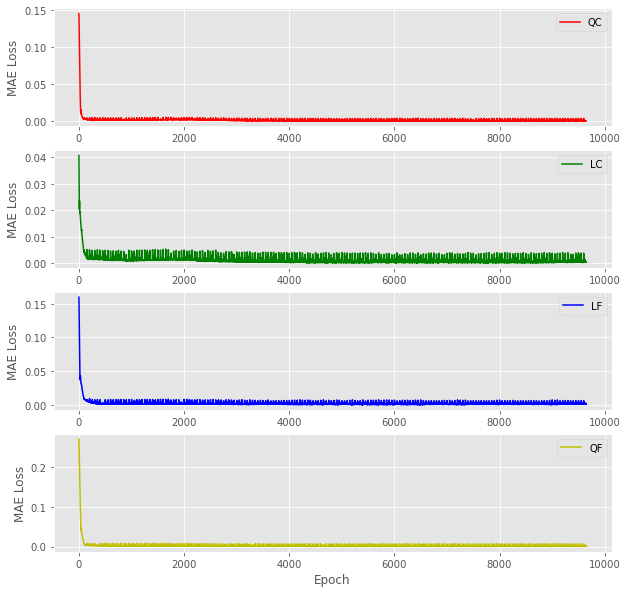

In [27]:
plt.figure(figsize=(10,10))
plt.figure(1)
ax1 = plt.subplot(411)
plt.plot(QCGCN_Loss_list_numpy,color='r',linestyle = "-",label='QC')
plt.legend(loc=1)
plt.ylabel('MAE Loss')
ax2 = plt.subplot(412)
plt.plot(LCGCN_Loss_list_numpy,color='g',linestyle = "-",label='LC')
plt.legend(loc=1)
plt.ylabel('MAE Loss')
ax3 = plt.subplot(413)
plt.plot(LFGCN_Loss_list_numpy,color='b',linestyle = "-",label='LF')
plt.legend(loc=1)
plt.ylabel('MAE Loss')
ax4= plt.subplot(414)
plt.plot(QFGCN_Loss_list_numpy,color='y',linestyle = "-",label='QF')
plt.legend(loc=1)
plt.ylabel('MAE Loss')
plt.xlabel('Epoch')
plt.show()

In [28]:
def gcn_valid(network,G,test_input,test_label,criterion,loss_list):
    for i in range(len(test_input)):
        loss = criterion(network(G,test_input[i]),test_label[i])
        loss_list.append(loss)

In [29]:
QCGCN_valid_loss_list=[];QCGCN_valid_loss_list.clear()
gcn_valid(QCGCN,GQC,valid_x,valid_y,nn.L1Loss(),QCGCN_valid_loss_list)

In [30]:
LCGCN_valid_loss_list=[];LCGCN_valid_loss_list.clear()
gcn_valid(LCGCN,GLC,valid_x,valid_y,nn.L1Loss(),LCGCN_valid_loss_list)

In [31]:
LFGCN_valid_loss_list=[];LFGCN_valid_loss_list.clear()
gcn_valid(LFGCN,GLF,valid_x,valid_y,nn.L1Loss(),LFGCN_valid_loss_list)

In [32]:
QFGCN_valid_loss_list=[];QFGCN_valid_loss_list.clear()
gcn_valid(QFGCN,GQF,valid_x,valid_y,nn.L1Loss(),QFGCN_valid_loss_list)

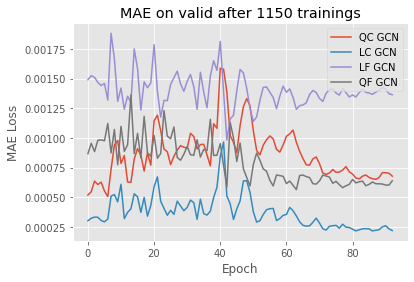

In [33]:
QCGCN_valid_loss_list_numpy = []
LCGCN_valid_loss_list_numpy = []
LFGCN_valid_loss_list_numpy = []
QFGCN_valid_loss_list_numpy = []
for i in QCGCN_valid_loss_list:
    QCGCN_valid_loss_list_numpy.append(i.detach().numpy())
for i in LCGCN_valid_loss_list:
    LCGCN_valid_loss_list_numpy.append(i.detach().numpy())
for i in LFGCN_valid_loss_list:
    LFGCN_valid_loss_list_numpy.append(i.detach().numpy())
for i in QFGCN_valid_loss_list:
    QFGCN_valid_loss_list_numpy.append(i.detach().numpy())

plt.plot(QCGCN_valid_loss_list_numpy,label='QC GCN')
plt.plot(LCGCN_valid_loss_list_numpy,label='LC GCN')
plt.plot(LFGCN_valid_loss_list_numpy,label='LF GCN')
plt.plot(QFGCN_valid_loss_list_numpy,label='QF GCN')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('MAE on valid after 1150 trainings')
plt.legend(loc=1)

In [34]:
def gcn_tester(network,G,test_input,test_label,criterion,loss_list):
    for i in range(len(test_input)):
        loss = criterion(network(G,test_input[i]),test_label[i])
        loss_list.append(loss)

In [35]:
QCGCN_test_loss_list=[];QCGCN_test_loss_list.clear()
gcn_tester(QCGCN,GQC,test_x,test_y,nn.L1Loss(),QCGCN_test_loss_list)

In [36]:
LCGCN_test_loss_list=[];LCGCN_test_loss_list.clear()
gcn_tester(LCGCN,GLC,test_x,test_y,nn.L1Loss(),LCGCN_test_loss_list)

In [37]:
LFGCN_test_loss_list=[];LFGCN_test_loss_list.clear()
gcn_tester(LFGCN,GLF,test_x,test_y,nn.L1Loss(),LFGCN_test_loss_list)

In [38]:
QFGCN_test_loss_list=[];QFGCN_test_loss_list.clear()
gcn_tester(QFGCN,GQF,test_x,test_y,nn.L1Loss(),QFGCN_test_loss_list)

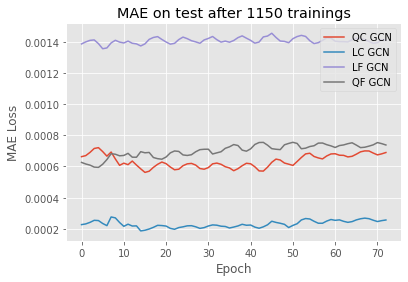

In [39]:
QCGCN_test_loss_list_numpy = []
LCGCN_test_loss_list_numpy = []
LFGCN_test_loss_list_numpy = []
QFGCN_test_loss_list_numpy = []

for i in QCGCN_test_loss_list:
    QCGCN_test_loss_list_numpy.append(i.detach().numpy())
    
for i in LCGCN_test_loss_list:
    LCGCN_test_loss_list_numpy.append(i.detach().numpy())
    
for i in LFGCN_test_loss_list:
    LFGCN_test_loss_list_numpy.append(i.detach().numpy())
    
for i in QFGCN_test_loss_list:
    QFGCN_test_loss_list_numpy.append(i.detach().numpy())

plt.plot(QCGCN_test_loss_list_numpy,label='QC GCN')
plt.plot(LCGCN_test_loss_list_numpy,label='LC GCN')
plt.plot(LFGCN_test_loss_list_numpy,label='LF GCN')
plt.plot(QFGCN_test_loss_list_numpy,label='QF GCN')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('MAE on test after 1150 trainings')
plt.legend(loc=1)

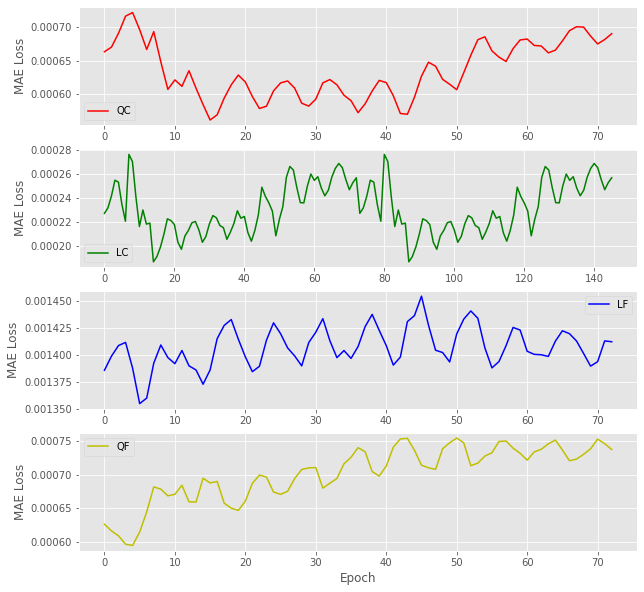

In [40]:
plt.figure(figsize=(10,10))
plt.figure(1)

QCGCN_test_loss_list_numpy = []
LCRGCN_test_loss_list_numpy = []
LFGCN_test_loss_list_numpy = []
QFGCN_test_loss_list_numpy = []

for i in QCGCN_test_loss_list:
    QCGCN_test_loss_list_numpy.append(i.detach().numpy())
for i in LCGCN_test_loss_list:
    LCGCN_test_loss_list_numpy.append(i.detach().numpy())
for i in LFGCN_test_loss_list:
    LFGCN_test_loss_list_numpy.append(i.detach().numpy())
for i in QFGCN_test_loss_list:
    QFGCN_test_loss_list_numpy.append(i.detach().numpy())

ax1 = plt.subplot(411)
plt.plot(QCGCN_test_loss_list_numpy,color="r",linestyle = "-",label='QC')
plt.ylabel('MAE Loss')
plt.legend()

ax2 = plt.subplot(412)
plt.plot(LCGCN_test_loss_list_numpy, color="g",linestyle = "-",label='LC')
plt.ylabel('MAE Loss')
plt.legend()

ax3 = plt.subplot(413)
plt.plot(LFGCN_test_loss_list_numpy,color="b",linestyle = "-",label='LF')
plt.ylabel('MAE Loss')
plt.legend()

ax4 = plt.subplot(414)
plt.plot(QFGCN_test_loss_list_numpy,color="y",linestyle = "-",label='QF')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()

In [41]:
mean_losslist(QCGCN_test_loss_list_numpy),mean_losslist(LCGCN_test_loss_list_numpy)

(0.0006350597800457315, 0.00023162410887953353)

In [42]:
mean_losslist(LFGCN_test_loss_list_numpy),mean_losslist(QFGCN_test_loss_list_numpy)

(0.0014070707232984778, 0.00070234648373029)

## RNN

In [43]:
class RNNs(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, layers, dropout=0):
        super(RNNs,self).__init__()

        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=layers, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, out_dim)


    def forward(self, x):
        out, hidden = self.rnn(x)
        channel_size,city_size,period_size = out.shape
        out = out.view(channel_size*city_size,period_size)
        out = self.linear(out)
        out = out.view(channel_size,city_size,-1)
        return out

In [44]:
def rnn_trainer(network,input_data,label_data,training_times,
                optimizer,criterion,loss_list,dur_list):

    #loss_list = loss_list
    #network = network

    for epoch in range(training_times):
        t0 = time.time()
        network.train()
        out = network(input_data)          
        
        #criterion = criterion
        loss = criterion(out,label_data)
        
        #optimizer = optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        dur_list.append(time.time() - t0)
        
        if (epoch+1) % 100 == 0:
            #acc = evaluate(net, g, features, labels, test_mask)
            print("Epoch {:04d} | MAE_Loss {:.4f}".format(epoch+1, loss.item())) 

In [45]:
RNN_Model = RNNs(7, 14, 1,2);RNN_Loss_list=[];RNN_Loss_list.clear();RNN_Dur_list=[]
rnn_trainer(RNN_Model,train_x,train_y,1150,th.optim.Adam(RNN_Model.parameters(), lr=1e-3),nn.L1Loss(),RNN_Loss_list,RNN_Dur_list)

Epoch 0100 | MAE_Loss 0.0060
Epoch 0200 | MAE_Loss 0.0035
Epoch 0300 | MAE_Loss 0.0024
Epoch 0400 | MAE_Loss 0.0028
Epoch 0500 | MAE_Loss 0.0028
Epoch 0600 | MAE_Loss 0.0027
Epoch 0700 | MAE_Loss 0.0026
Epoch 0800 | MAE_Loss 0.0025
Epoch 0900 | MAE_Loss 0.0025
Epoch 1000 | MAE_Loss 0.0024
Epoch 1100 | MAE_Loss 0.0023


No handles with labels found to put in legend.


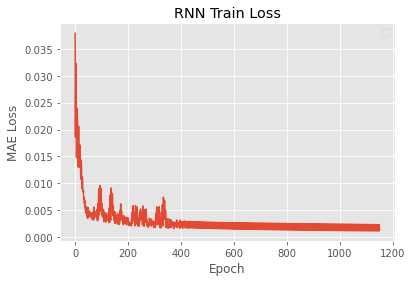

In [46]:
RNN_Loss_list_numpy =[]
for i in RNN_Loss_list:
    RNN_Loss_list_numpy.append(i.detach().numpy())
    
plt.style.use('ggplot')
plt.plot(RNN_Loss_list_numpy)
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('RNN Train Loss')
plt.legend()

In [47]:
mean_losslist(RNN_Loss_list_numpy)

0.0029549482594365658

In [48]:
def rnn_tester(network,test_input,test_label,criterion,loss_list):
    loss = criterion(network(test_input),test_label)
    loss_list.append(loss)

In [49]:
RNN_test_loss_list=[];RNN_test_loss_list.clear()
rnn_tester(RNN_Model,test_x,test_y,nn.L1Loss(),RNN_test_loss_list)

In [50]:
RNN_test_loss_list_numpy = []
for i in RNN_test_loss_list:
    RNN_test_loss_list_numpy.append(i.detach().numpy())
mean_losslist(RNN_test_loss_list_numpy)

0.0011692469706758857

## LSTM

In [51]:
class LSTMs(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, layers, dropout=0):
        super(LSTMs,self).__init__()

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=layers, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, out_dim)


    def forward(self, x):
        out, hidden = self.lstm(x)
        channel_size,city_size,period_size = out.shape
        out = out.view(channel_size*city_size,period_size)
        out = self.linear(out)
        out = out.view(channel_size,city_size,-1)
        return out

In [52]:
LSTM_Model=LSTMs(7,14,1,2)

In [53]:
def lstm_trainer(network,input_data,label_data,training_times,
                optimizer,criterion,loss_list,dur_list):

    #loss_list = loss_list
    #network = network

    for epoch in range(training_times):
        t0 = time.time()
        network.train()
        out = network(input_data)          
        
        #criterion = criterion
        loss = criterion(out,label_data)
        
        #optimizer = optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        dur_list.append(time.time() - t0)
        
        if (epoch+1) % 100 == 0:
            #acc = evaluate(net, g, features, labels, test_mask)
            print("Epoch {:04d} | MAE_Loss {:.4f}".format(epoch+1, loss.item())) 

In [54]:
LSTM_Loss_list=[];LSTM_Loss_list.clear();LSTM_Dur_list=[]
lstm_trainer(LSTM_Model,train_x,train_y,1150,th.optim.Adam(LSTM_Model.parameters(), lr=1e-3),nn.L1Loss(),LSTM_Loss_list,LSTM_Dur_list)

Epoch 0100 | MAE_Loss 0.0123
Epoch 0200 | MAE_Loss 0.0041
Epoch 0300 | MAE_Loss 0.0029
Epoch 0400 | MAE_Loss 0.0031
Epoch 0500 | MAE_Loss 0.0028
Epoch 0600 | MAE_Loss 0.0021
Epoch 0700 | MAE_Loss 0.0022
Epoch 0800 | MAE_Loss 0.0023
Epoch 0900 | MAE_Loss 0.0017
Epoch 1000 | MAE_Loss 0.0019
Epoch 1100 | MAE_Loss 0.0020


No handles with labels found to put in legend.


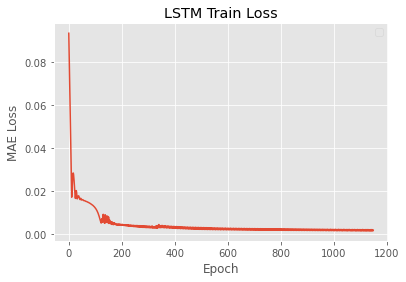

In [55]:
LSTM_Loss_list_numpy = []
for i in LSTM_Loss_list:
    LSTM_Loss_list_numpy.append(i.detach().numpy())

plt.style.use('ggplot')
plt.plot(LSTM_Loss_list_numpy)
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('LSTM Train Loss')
plt.legend()

In [56]:
mean_losslist(LSTM_Loss_list_numpy)

0.004434998553732167

In [57]:
def lstm_tester(network,test_input,test_label,criterion,loss_list):
    loss = criterion(network(test_input),test_label)
    loss_list.append(loss)

In [58]:
LSTM_test_loss_list=[];LSTM_test_loss_list.clear()
lstm_tester(LSTM_Model,test_x,test_y,nn.L1Loss(),LSTM_test_loss_list)

In [59]:
LSTM_test_loss_list_numpy = []
for i in LSTM_test_loss_list:
    LSTM_test_loss_list_numpy.append(i.detach().numpy())
mean_losslist(LSTM_test_loss_list_numpy)

0.0023245415650308132

## GRU

In [60]:
class GRUs(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, layers, dropout=0):
        super(GRUs,self).__init__()

        self.lstm = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=layers, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, out_dim)


    def forward(self, x):
        out, hidden = self.lstm(x)
        channel_size,city_size,period_size = out.shape
        out = out.view(channel_size*city_size,period_size)
        out = self.linear(out)
        out = out.view(channel_size,city_size,-1)
        return out

In [61]:
GRU_Model=GRUs(7,14,1,2)

In [62]:
def gru_trainer(network,input_data,label_data,training_times,
                optimizer,criterion,loss_list,dur_list):

    #loss_list = loss_list
    #network = network

    for epoch in range(training_times):
        t0 = time.time()
        network.train()
        out = network(input_data)          
        
        #criterion = criterion
        loss = criterion(out,label_data)
        
        #optimizer = optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        dur_list.append(time.time() - t0)
        
        if (epoch+1) % 100 == 0:
            #acc = evaluate(net, g, features, labels, test_mask)
            print("Epoch {:04d} | MAE_Loss {:.4f}".format(epoch+1, loss.item())) 

In [63]:
GRU_Loss_list=[];GRU_Loss_list.clear();GRU_Dur_list=[]
gru_trainer(GRU_Model,train_x,train_y,1150,th.optim.Adam(GRU_Model.parameters(), lr=1e-3),nn.L1Loss(),GRU_Loss_list,GRU_Dur_list)

Epoch 0100 | MAE_Loss 0.0031
Epoch 0200 | MAE_Loss 0.0031
Epoch 0300 | MAE_Loss 0.0033
Epoch 0400 | MAE_Loss 0.0033
Epoch 0500 | MAE_Loss 0.0027
Epoch 0600 | MAE_Loss 0.0029
Epoch 0700 | MAE_Loss 0.0027
Epoch 0800 | MAE_Loss 0.0023
Epoch 0900 | MAE_Loss 0.0025
Epoch 1000 | MAE_Loss 0.0025
Epoch 1100 | MAE_Loss 0.0019


No handles with labels found to put in legend.


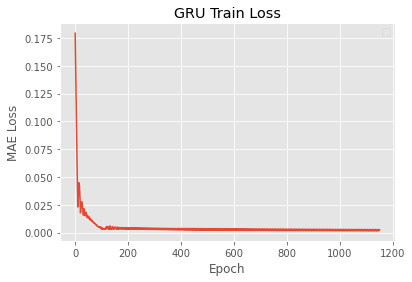

In [64]:
GRU_Loss_list_numpy = []
for i in GRU_Loss_list:
    GRU_Loss_list_numpy.append(i.detach().numpy())

plt.style.use('ggplot')
plt.plot(GRU_Loss_list_numpy)
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('GRU Train Loss')
plt.legend()

In [65]:
mean_losslist(GRU_Loss_list_numpy)

0.004591489045516304

In [66]:
def gru_tester(network,test_input,test_label,criterion,loss_list):
    loss = criterion(network(test_input),test_label)
    loss_list.append(loss)

In [67]:
GRU_test_loss_list=[];GRU_test_loss_list.clear()
gru_tester(GRU_Model,test_x,test_y,nn.L1Loss(),GRU_test_loss_list)

In [68]:
GRU_test_loss_list_numpy = []
for i in GRU_test_loss_list:
    GRU_test_loss_list_numpy.append(i.detach().numpy())
    
mean_losslist(GRU_test_loss_list_numpy)

0.001223703846335411

## 综合分析

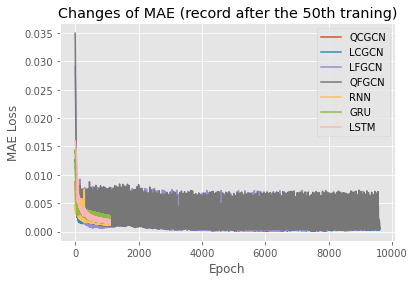

In [69]:
plt.style.use('ggplot')
plt.plot(QCGCN_Loss_list_numpy[50:],label='QCGCN')
plt.plot(LCGCN_Loss_list_numpy[50:],label='LCGCN')
plt.plot(LFGCN_Loss_list_numpy[50:],label='LFGCN')
plt.plot(QFGCN_Loss_list_numpy[50:],label='QFGCN')
plt.plot(RNN_Loss_list_numpy[50:],label='RNN')
plt.plot(GRU_Loss_list_numpy[50:],label='GRU')
plt.plot(LSTM_Loss_list_numpy[50:],label='LSTM')

plt.title('Changes of MAE (record after the 50th traning)')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend(loc=1)
plt.show()

In [70]:
QCGCN_test_loss_list

[tensor(0.0007, grad_fn=<L1LossBackward>),
 tensor(0.0007, grad_fn=<L1LossBackward>),
 tensor(0.0007, grad_fn=<L1LossBackward>),
 tensor(0.0007, grad_fn=<L1LossBackward>),
 tensor(0.0007, grad_fn=<L1LossBackward>),
 tensor(0.0007, grad_fn=<L1LossBackward>),
 tensor(0.0007, grad_fn=<L1LossBackward>),
 tensor(0.0007, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0006, grad_fn=<L1LossBackward>),
 tensor(0.0

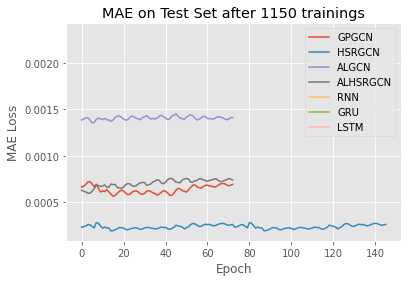

In [71]:
plt.plot(QCGCN_test_loss_list_numpy,label='GPGCN')
plt.plot(LCGCN_test_loss_list_numpy,label='HSRGCN')
plt.plot(LFGCN_test_loss_list_numpy,label='ALGCN')
plt.plot(QFGCN_test_loss_list_numpy,label='ALHSRGCN')
plt.plot(RNN_test_loss_list_numpy,label='RNN')
plt.plot(GRU_test_loss_list_numpy,label='GRU')
plt.plot(LSTM_test_loss_list_numpy,label='LSTM')

plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
#plt.ylim(0.000,0.4)
plt.title('MAE on Test Set after 1150 trainings')
plt.legend()

In [72]:
RNN_During,LSTM_During,GRU_During=np.sum(RNN_Dur_list),np.sum(LSTM_Dur_list),np.sum(GRU_Dur_list)
RNN_During,LSTM_During,GRU_During

(90.62070488929749, 382.81424927711487, 431.9127905368805)

In [73]:
MAE_LIST=[mean_losslist(QCGCN_test_loss_list_numpy).item(),
 mean_losslist(LCGCN_test_loss_list_numpy).item(),
 mean_losslist(LFGCN_test_loss_list_numpy).item(),
 mean_losslist(QFGCN_test_loss_list_numpy).item(),
           mean_losslist(RNN_test_loss_list_numpy).item(),
          mean_losslist(GRU_test_loss_list_numpy).item(),
           mean_losslist(LSTM_test_loss_list_numpy).item()]
DUR_LIST=[QCGCN_During,LCGCN_During,LFGCN_During,QFGCN_During,RNN_During,GRU_During,LSTM_During]
NAME_LIST=['QC GCN','LC GCN',"LF GCN","QF GCN",'RNN','GRU','LSTM']

In [74]:
len(MAE_LIST),len(DUR_LIST),len(NAME_LIST)

(7, 7, 7)

In [75]:
MAEDUR_dict={'MAE':MAE_LIST,'DUR':DUR_LIST,'NAME':NAME_LIST}
MAEDUR=pd.DataFrame(MAEDUR_dict)
MAEDUR=MAEDUR.set_index(MAEDUR['NAME'])
MAEDUR

,MAE,DUR,NAME
NAME,,,
QC GCN,0.000635,20.244357,QC GCN
LC GCN,0.000232,24.509230,LC GCN
LF GCN,0.001407,27.204679,LF GCN
QF GCN,0.000702,28.986290,QF GCN
RNN,0.001169,90.620705,RNN
GRU,0.001224,431.912791,GRU
LSTM,0.002325,382.814249,LSTM


<ipython-input-76-52fd8891e030>:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


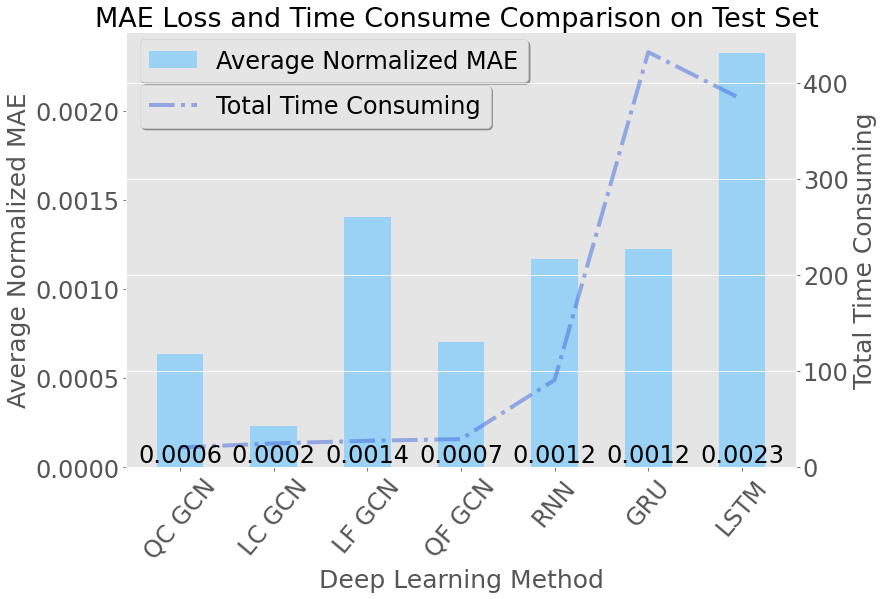

In [76]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
plt.xticks(rotation=50,fontsize=24)
plt.yticks(fontsize=24)
plt.grid(False) 
ax1=ax.twinx()

ax1.plot(MAEDUR['DUR'],color='#4169E1',linewidth=4,label='Total Time Consuming',alpha=0.5,linestyle = '-.')


ax.bar(MAEDUR['NAME'],MAEDUR['MAE'],width=0.5,label='Average Normalized MAE',color='#87CEFA',alpha=0.8)
#ax.legend(loc='best')

plt.yticks(fontsize=24)
ax.set_xlabel(r'Deep Learning Method',fontsize=25)
ax.set_ylabel(r'Average Normalized MAE',fontsize=25)     #plt.xticks(rotation=50,fontsize=13)



ax1.set_ylabel(r'Total Time Consuming',fontsize=25)
#plt.legend(loc=2,fontsize=14)


legend1=ax.legend(loc=(.02,.885),fontsize=24,shadow=True)
legend2=ax1.legend(loc=(.02,.78),fontsize=24,shadow=True)





for a,b in zip(MAEDUR.index,MAEDUR['MAE']):
    plt.text(a, b, '%.4f' % b, ha='center', va="bottom",fontsize=24)

'''
for a,b in zip(MAEDUR.index,MAEDUR['DUR']):
    plt.text(a, b+0.5, '%.2f' % b, ha='center', va="bottom",fontsize=16)
'''


plt.title('MAE Loss and Time Consume Comparison on Test Set ',fontsize=27) 

fig.show()